<a href="https://colab.research.google.com/github/anggisotomani/My_Project/blob/main/Skripsi_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY**

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
import datetime as dt
import re
import string
import ipywidgets as widgets

from io import StringIO
from IPython.display import display
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from scipy import sparse
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# **LOADING DATASET**

In [ ]:
# Download dataset dari GitHub
!wget -O dataset.csv "https://raw.githubusercontent.com/anggisotomani/Dataset/refs/heads/main/Dataset_OjekOnline_Apps.csv"

In [ ]:
df = pd.read_csv('/content/dataset.csv')
df

In [ ]:
df.info()

In [ ]:
clean_df = df.dropna()

In [ ]:
clean_df = clean_df.drop_duplicates()
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [ ]:
clean_df.info()

# **PREPROCESSING TEXT**

In [ ]:
# Fungsi cleaningText yang diperbaiki (tanpa redundansi)
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))  # Opsi 2 untuk tanda baca
    text = text.strip()
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

# Fungsi filteringText yang dioptimasi
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords.update(stopwords.words('english'))
    listStopwords.update(['iya', 'yaa', 'nya', 'na', 'b', 'pa', 'eh', 'yang', 'dri', 'ny', 'dr', 'utk', 'deh', 'sih', 'aja', 'ku'])
    return [word for word in text if word not in listStopwords]

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
# Ambil data slangword dari URL
url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv"

def load_slangwords():
    df = pd.read_csv(url)
    slang_dict = dict(zip(df['slang'], df['formal']))
    return slang_dict

# Load slangword dictionary sekali saja agar tidak berulang-ulang di apply()
kamus_alay = load_slangwords()

def fix_slangwords(text):
    words = text.split()
    res = [kamus_alay.get(word, word) for word in words]
    return " ".join(res)

In [ ]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_final'] = clean_df['text_stopword'].apply(toSentence)  # atau langsung dari text_stopword jika tidak menggunakan stemming

clean_df.head(10)

content  appName  \
0            Tiap update pasti selalu sepi orderan🥴🥴  inDrive   
1                BOROS GINI BATRAINYA BAIS DI UPDATE  inDrive   
2         Apk sangat bagus tapi Auto Beat Bermasalah  inDrive   
3                                               baik  inDrive   
4                                    sangat membantu  inDrive   
5                                             Mantap  inDrive   
6  Akun d blokir karena sering cancel padahal dri...  inDrive   
7                                    mudah dan hemat  inDrive   
8  Map di tempat saya sala seharusnya jembatan da...  inDrive   
9                                                👍👍👍  inDrive   

                                          text_clean  \
0              Tiap update pasti selalu sepi orderan   
1                BOROS GINI BATRAINYA BAIS DI UPDATE   
2         Apk sangat bagus tapi Auto Beat Bermasalah   
3                                               baik   
4                                    sangat membantu   
5                                             Mantap   
6  Akun d blokir karena sering cancel padahal dri...   
7                                    mudah dan hemat   
8  Map di tempat saya sala seharusnya jembatan da...   
9                                                      

                                text_casefoldingText  \
0              tiap update pasti selalu sepi orderan   
1                boros gini batrainya bais di update   
2         apk sangat bagus tapi auto beat bermasalah   
3                                               baik   
4                                    sangat membantu   
5                                             mantap   
6  akun d blokir karena sering cancel padahal dri...   
7                                    mudah dan hemat   
8  map di tempat saya sala seharusnya jembatan da...   
9                                                      

                                     text_slangwords  \
0              tiap update pasti selalu sepi orderan   
1              boros begini batrainya bais di update   
2         apk sangat bagus tapi auto beat bermasalah   
3                                               baik   
4                                    sangat membantu   
5                                             mantap   
6  akun di blokir karena sering cancel padahal dr...   
7                                    mudah dan hemat   
8  map di tempat saya sala seharusnya jembatan da...   
9                                                      

                                 text_tokenizingText  \
0       [tiap, update, pasti, selalu, sepi, orderan]   
1       [boros, begini, batrainya, bais, di, update]   
2  [apk, sangat, bagus, tapi, auto, beat, bermasa...   
3                                             [baik]   
4                                 [sangat, membantu]   
5                                           [mantap]   
6  [akun, di, blokir, karena, sering, cancel, pad...   
7                                [mudah, dan, hemat]   
8  [map, di, tempat, saya, sala, seharusnya, jemb...   
9                                                 []   

                                       text_stopword  \
0                            [update, sepi, orderan]   
1                   [boros, batrainya, bais, update]   
2               [apk, bagus, auto, beat, bermasalah]   
3                                                 []   
4                                         [membantu]   
5                                           [mantap]   
6  [akun, blokir, cancel, drivernya, cancel, alasan]   
7                                     [mudah, hemat]   
8  [map, sala, jembatan, lorong, lorong, jembatan...   
9                                                 []   

                                          text_final  
0                                update sepi orderan  
1                        boros batrainya bais update  
2                     apk bagus auto beat bermasalah  
3                       

In [ ]:
# Menghapus kata-kata Slang
slangwords = {
    "@": "di",
    "abis": "habis",
    "apk": "aplikasi",
    "app": "aplikasi",
    "dapet": "dapat",
    "wtb": "beli",
    "masi": "masih",
    "wts": "jual",
    "wtt": "tukar",
    "bgt": "banget",
    "bagu": "bagus",
    "bgus": "bagus",
    "ok": "oke",
    "gw": "saya",
    "maks": "maksimal",
    "mantab": "mantap",
    "indriver": "indrive",
    "gk": "tidak",
    "sy": "saya",
    "udah": "sudah",
    "sdh": "sudah",
    "cs": "teman",
    "bener": "benar",
    "parah": "buruk",
    "rb": "ribu",
    "tp": "tapi",
    "tpi": "tapi",
    "deket": "dekat",
    "cuman": "cuma",
    "mulu": "selalu",
    "ni": "ini",
    "jelek": "buruk",
    "jd": "jadi",
    "lg": "lagi",
    "drivernya": "driver",
    "sistemnya": "sistem",
    "pengemudi": "driver",
    "titik": "alamat",
    "ongkos": "biaya",
    "potongan": "diskon",
    "tdk": "tidak",
    "min": "anda",
    "nggak": "tidak",
    "ga": "tidak",
    "gak": "tidak",
    "pesen": "pesan",
    "sampe": "sampai",
    "pake": "pakai",
    "cepet": "cepat",
    "nih": "ini",
    "jgn": "jangan",
    "map": "peta",
    "klo": "kalau",
    "eror": "error",
    "dpt": "dapat",
    "jg": "juga",
    "bagussssssssss": "bagus",
    "ngga": "tidak",
    "mod": "modifikasi",
    "trus": "terus",
    "batalin": "batal",
    "maling": "pencuri",
    "jelasss": "jelas",
    "ngeselin": "menyebalkan",
    "dev": "developer",
    "mah": "saja",
    "pdhl": "padahal",
    "maps": "peta",
    "udh": "sudah",
    "blm": "belum",
    "mantul": "mantap",
    "bln": "bulan",
    "notif": "notifikasi",
    "g": "tidak",
    "priorita": "prioritas",
    "ancur": "hancur",
    "jdi": "jadi",
    "karna": "karena",
    "mantappp": "mantap",
    "grap": "grab",
    "trimakasih": "terimakasih",
    "supirnya": "driver",
    "mantapp": "mantap",
    "cpt": "cepat",
    "gampang": "mudah",
    "kek": "macam",
    "org": "orang",
    "mantaf": "mantap",
    "dlm": "dalam",
    "kerenn":"keren",
    "mambatu": "membantu",
    "mmbantu": "membantu",
    "mantapppp": "mantap",
    "mantp": "mantap",
    "mantappa": "mantap",
    "mntap": "mantap",
    "mantaap": "mantap",
    "baikk": "baik",
    "greb": "grab",
    "sngt": "sangat",
    "lgsg": "langsung",
    "nomer": "nomor",
    "mesen": "pesan",
    "tetep": "tetap",
    "gx": "tidak",
    "kemaren": "kemarin",
    "kalo": "kalau",
    "lgsg": "langsung",
    "slalu": "selalu",
    "jga": "juga",
    "tlg": "tolong",
    "pengen": "ingin",
    "sllu": "selalu",
    "nyesel": "menyesal",
    "kl": "kalau",
    "liat": "lihat",
    "bs": "bisa",
    "rp": "rupiah",
    "males": "malas",
    "make": "pakai",
    "smpe": "sampai",
    "uda": "sudah",
    "bales": "balas",
    "perbaikin": "perbaiki",
    "nunggu": "tunggu",
    "friendly": "ramah",
    "kasi": "kasih",
    "dlu": "dulu",
    "nambah": "tambah",
    "cust": "customer",
    "emang": "memang",
    "segitu": "begitu",
    "benerin": "memperbaiki",
    "cust": "customer",
    "kya": "seperti",
    "gtu": "gitu",
    "smoga": "semoga",
    "baguss": "bagus",
    "msh": "masih",
    "lbh": "lebih",
    "sm": "sama",
    "pakek": "pakai",
    "nego": "negosiasi",
    "nga": "tidak",
    "makasi": "makasih",
    "doang": "saja",
    "cansel": "batal",
    "cape": "lelah",
    "dah": "sudah",
    "knapa": "kenapa",
    "ngelag": "lag",
    "lemot": "lag",
    "nyampe": "sampai",
    "gua": "aku",
    "trs": "terus",
    "wktu": "waktu",
    "bsa": "bisa",
    "hrs": "harus",
    "anter": "antar",
    "ngaco": "kacau",
    "kk": "kakak",
    "apps": "aplikasi",
    "smua": "semua",
    "sya": "saya",
    "sngat": "sangat"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [4]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_stemming'] = clean_df['text_stopword'].apply(toSentence).apply(stemmingText)  # Tambahkan stemming jika diperlukan
clean_df['text_final'] = clean_df['text_stemming']  # atau langsung dari text_stopword jika tidak menggunakan stemming

NameError: name 'clean_df' is not defined

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13901 entries, 0 to 19997
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               13901 non-null  object
 1   appName               13901 non-null  object
 2   text_clean            13901 non-null  object
 3   text_casefoldingText  13901 non-null  object
 4   slangwords            13901 non-null  object
 5   text_tokenizingText   13901 non-null  object
 6   text_stopword         13901 non-null  object
 7   text_final            13901 non-null  object
 8   text_slangwords       13901 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_final'] = clean_df['text_stopword'].apply(toSentence)

# Tampilkan
clean_df.head()

userName  score                   at  \
0  Pengguna Google      5  2024-12-20 12:57:42   
1  Pengguna Google      1  2024-12-20 12:55:01   
2  Pengguna Google      5  2024-12-20 12:45:41   
3  Pengguna Google      1  2024-12-20 12:42:27   
4  Pengguna Google      1  2024-12-20 12:35:55   

                                             content  appName  \
0                                              keren  inDrive   
1                  Aplikasi jelek buruk banget...👎👎👎  inDrive   
2                                               good  inDrive   
3  Aplikasi penjahat , Maling uang driver , sy se...  inDrive   
4  Hey dev, udah mah aplikasi tidak kompatibel di...  inDrive   

                                          text_clean  \
0                                              keren   
1                        Aplikasi jelek buruk banget   
2                                               good   
3  Aplikasi penjahat  Maling uang driver  sy seor...   
4  Hey dev udah mah aplikasi tidak kompatibel di ...   

                                text_casefoldingText  \
0                                              keren   
1                        aplikasi jelek buruk banget   
2                                               good   
3  aplikasi penjahat  maling uang driver  sy seor...   
4  hey dev udah mah aplikasi tidak kompatibel di ...   

                                     text_slangwords  \
0                                              keren   
1                        aplikasi buruk buruk banget   
2                                               good   
3  aplikasi penjahat pencuri uang driver saya seo...   
4  hey developer sudah saja aplikasi tidak kompat...   

                                 text_tokenizingText  \
0                                            [keren]   
1                   [aplikasi, buruk, buruk, banget]   
2                                             [good]   
3  [aplikasi, penjahat, pencuri, uang, driver, sa...   
4  [hey, developer, sudah, saja, aplikasi, tidak,...   

                                       text_stopword  \
0                                            [keren]   
1                   [aplikasi, buruk, buruk, banget]   
2                                             [good]   
3  [aplikasi, penjahat, pencuri, uang, driver, dr...   
4  [hey, developer, aplikasi, kompatibel, perangk...   

                                          text_final  
0                                              keren  
1                        aplikasi buruk buruk banget  
2                                               good  
3  aplikasi penjahat pencuri uang driver driver k...  
4  hey developer aplikasi kompatibel perangkat dr...

# **LABELING**

In [ ]:
# Membuat dictionary kosong untuk menyimpan kata-kata positif beserta nilai intensitasnya
lexicon_positive = dict()

# Mengambil data lexicon positif dari URL
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

# Mengecek apakah permintaan HTTP berhasil (status code 200)
if response.status_code == 200:
    # Membaca data CSV dari respons teks menggunakan csv.reader
    reader = csv.reader(StringIO(response.text), delimiter=',')

    # Memasukkan setiap baris data ke dalam dictionary lexicon_positive
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])  # row[0]: kata, row[1]: nilai intensitas
else:
    # Menampilkan pesan kesalahan jika gagal mengambil data
    print("Failed to fetch positive lexicon data")

# Membuat dictionary kosong untuk menyimpan kata-kata negatif beserta nilai intensitasnya
lexicon_negative = dict()

# Mengambil data lexicon negatif dari URL
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

# Mengecek apakah permintaan HTTP berhasil (status code 200)
if response.status_code == 200:
    # Membaca data CSV dari respons teks menggunakan csv.reader
    reader = csv.reader(StringIO(response.text), delimiter=',')

    # Memasukkan setiap baris data ke dalam dictionary lexicon_negative
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])  # row[0]: kata, row[1]: nilai intensitas
else:
    # Menampilkan pesan kesalahan jika gagal mengambil data
    print("Failed to fetch negative lexicon data")

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    # Inisialisasi variabel skor untuk menghitung nilai sentimen
    score = 0

    # Menghitung skor berdasarkan lexicon positif
    for word in text:  # Iterasi setiap kata dalam teks
        if word in lexicon_positive:  # Jika kata ada dalam lexicon positif
            score = score + lexicon_positive[word]  # Tambahkan nilai kata ke skor

    # Menghitung skor berdasarkan lexicon negatif
    for word in text:  # Iterasi setiap kata dalam teks
        if word in lexicon_negative:  # Jika kata ada dalam lexicon negatif
            score = score + lexicon_negative[word]  # Tambahkan nilai kata ke skor (negatif)

    # Menentukan polaritas berdasarkan skor akhir
    polarity = ''  # Inisialisasi variabel polaritas sebagai string kosong
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity


In [ ]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    6524
negative    4371
neutral     3006
Name: count, dtype: int64


# **VISUALISASI**

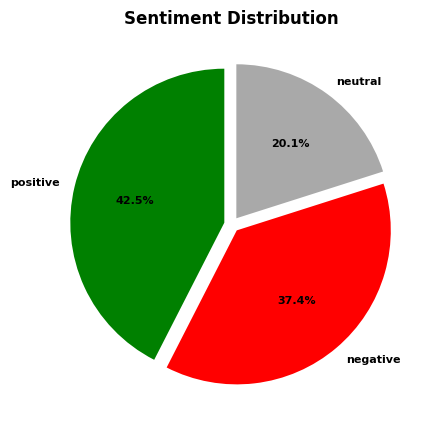

In [ ]:
# Data sentiment
sentiment_counts = clean_df['polarity'].value_counts()

# Memberi jarak Chart
explode = [0.05] * len(sentiment_counts)

# Membuat pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#008000', '#FF0000', '#A9A9A9'],
    explode=explode,
    textprops={'fontsize': 8, 'weight': 'bold'}
)
plt.title('Sentiment Distribution', fontsize=12, weight='bold')
plt.show()


<Figure size 1200x600 with 0 Axes>

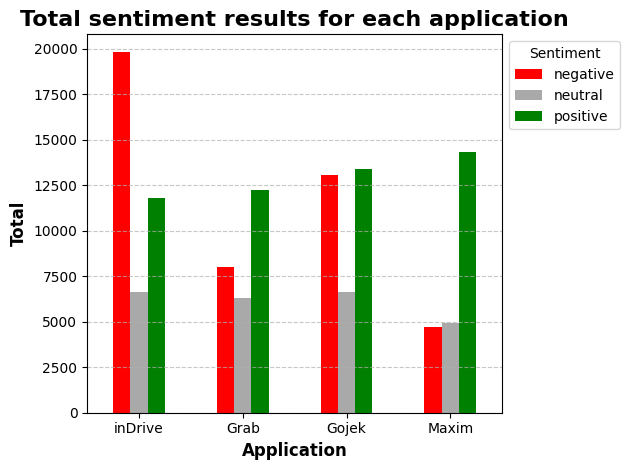

<Figure size 1200x600 with 0 Axes>

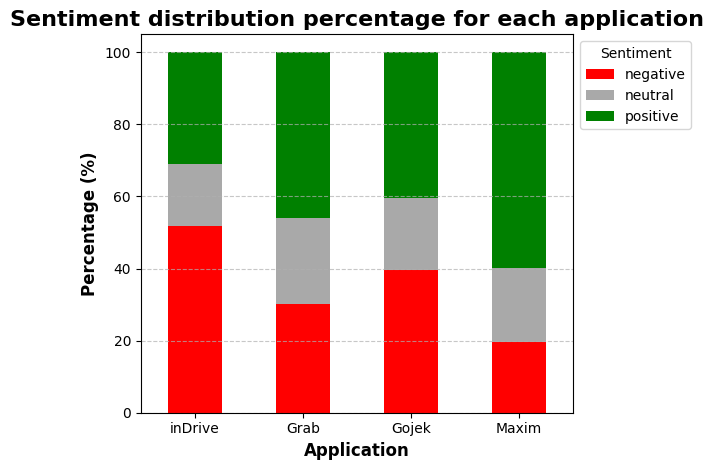

In [ ]:
# Data preparation
applications = ['inDrive', 'Grab', 'Gojek', 'Maxim']

# Filter and summarize sentiment counts
summary_data = clean_df.groupby(['appName', 'polarity']).size().unstack(fill_value=0).loc[applications]

# Grafik batang: Jumlah absolut sentimen
plt.figure(figsize=(12, 6))
summary_data.plot(kind='bar', stacked=False, color=['#FF0000', '#A9A9A9', '#008000'])
plt.title('Total sentiment results for each application', fontsize=16, weight='bold')
plt.ylabel('Total', fontsize=12, weight='bold')
plt.xlabel('Application', fontsize=12, weight='bold')
plt.xticks(rotation=0)
plt.legend(title='Sentiment', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Grafik batang bertumpuk: Persentase distribusi sentimen
summary_percent = (summary_data.T / summary_data.sum(axis=1)).T * 100

plt.figure(figsize=(12, 6))
summary_percent.plot(kind='bar', stacked=True, color=['#FF0000', '#A9A9A9', '#008000'])
plt.title('Sentiment distribution percentage for each application', fontsize=16, weight='bold')
plt.ylabel('Percentage (%)', fontsize=12, weight='bold')
plt.xlabel('Application', fontsize=12, weight='bold')
plt.xticks(rotation=0)
plt.legend(title='Sentiment', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Tabel ringkasan
summary_data['Total'] = summary_data.sum(axis=1)
summary_percent['Positive (%)'] = summary_percent['positive']
summary_percent['Neutral (%)'] = summary_percent['neutral']
summary_percent['Negative (%)'] = summary_percent['negative']

summary_table = pd.concat([summary_data, summary_percent[['Positive (%)', 'Neutral (%)', 'Negative (%)']]], axis=1)
print(summary_table)

polarity  negative  neutral  positive  Total  Positive (%)  Neutral (%)  \
appName                                                                   
inDrive      19795     6604     11797  38196     30.885433    17.289769   
Grab          8018     6327     12227  26572     46.014602    23.810778   
Gojek        13085     6606     13407  33098     40.506979    19.958910   
Maxim         4728     4947     14339  24014     59.711002    20.600483   

polarity  Negative (%)  
appName                 
inDrive      51.824798  
Grab         30.174620  
Gojek        39.534111  
Maxim        19.688515  


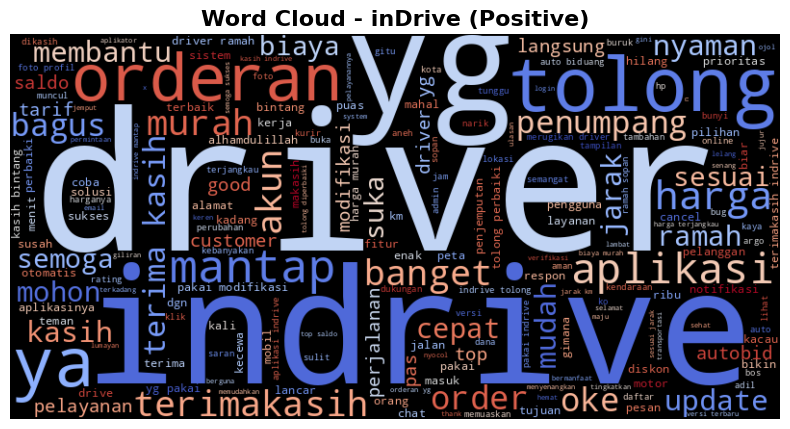

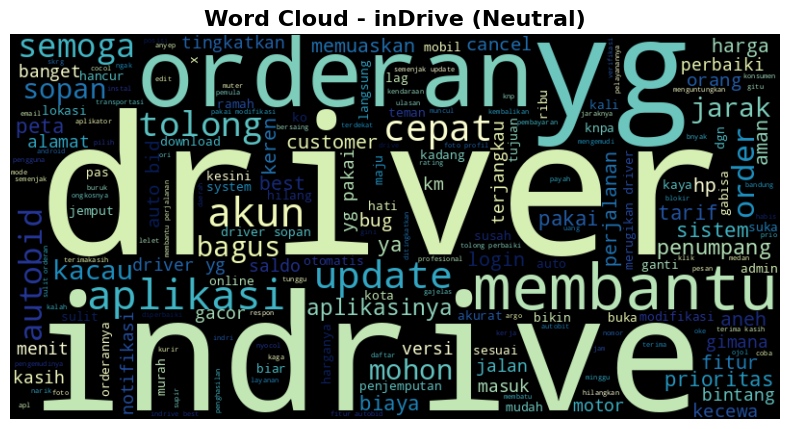

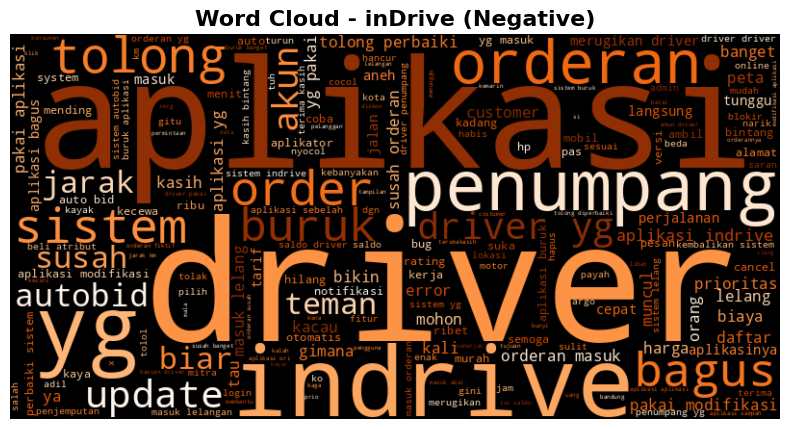

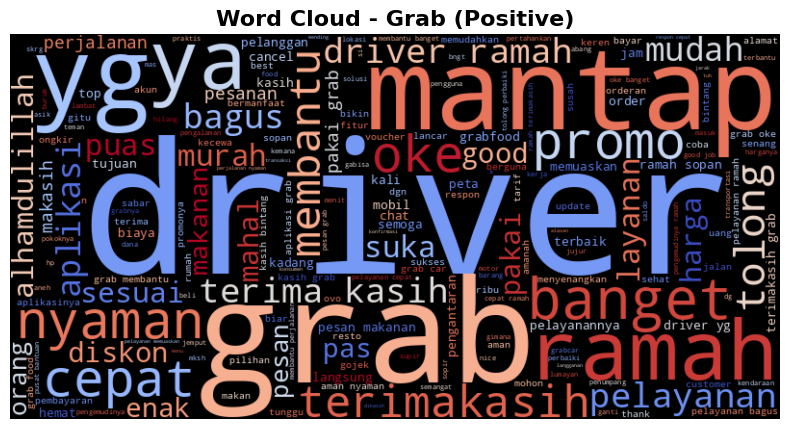

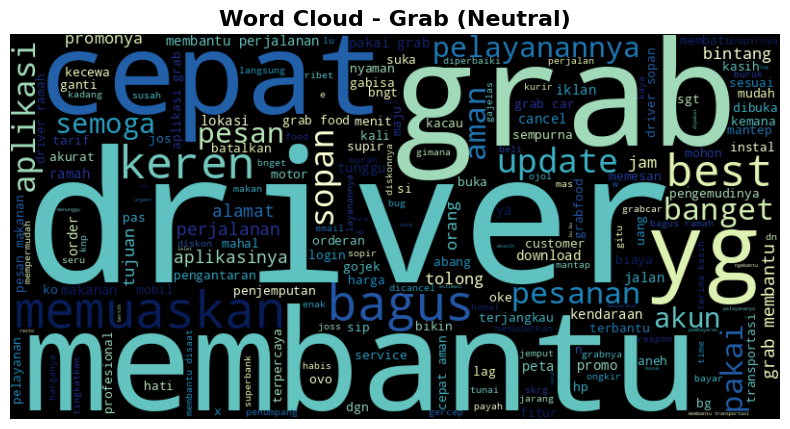

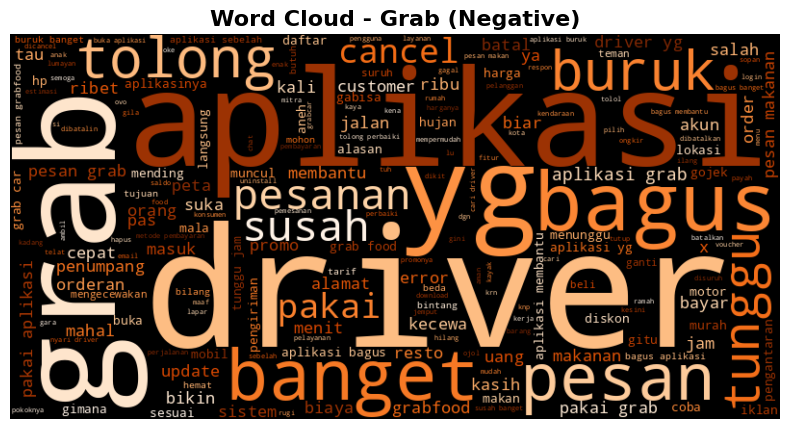

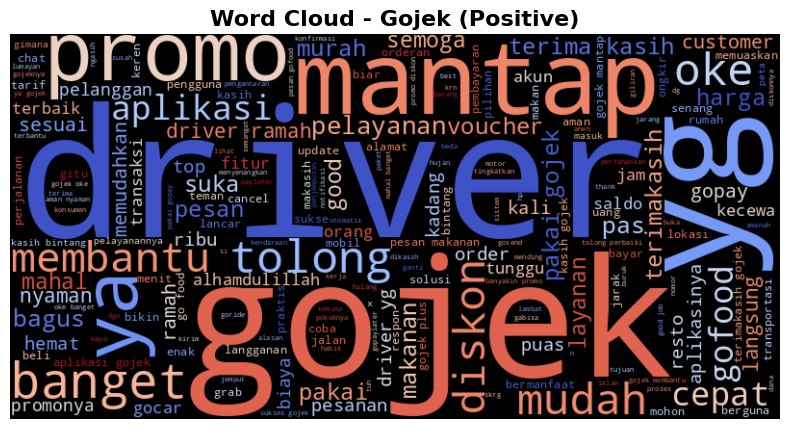

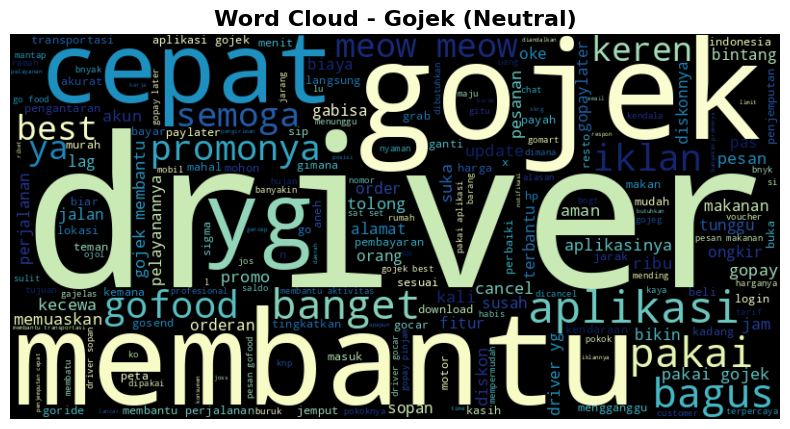

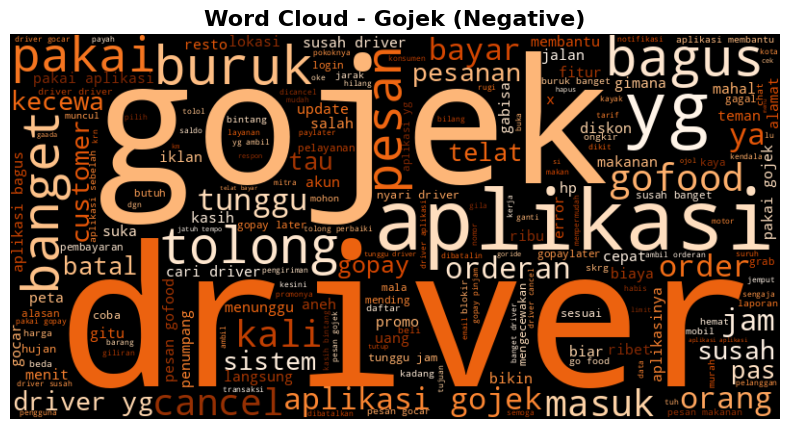

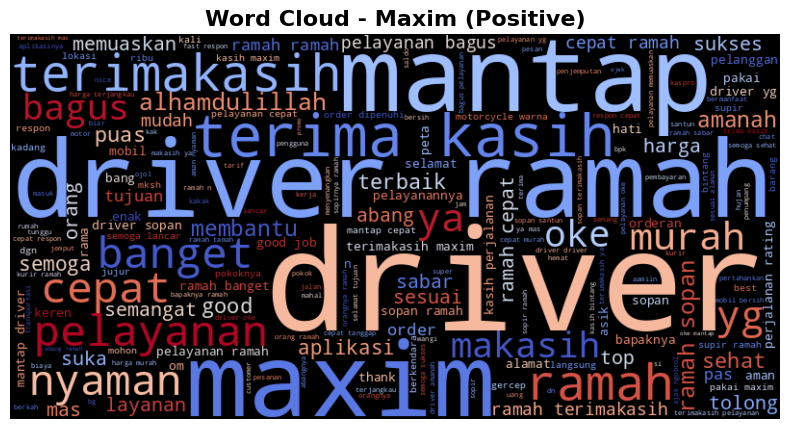

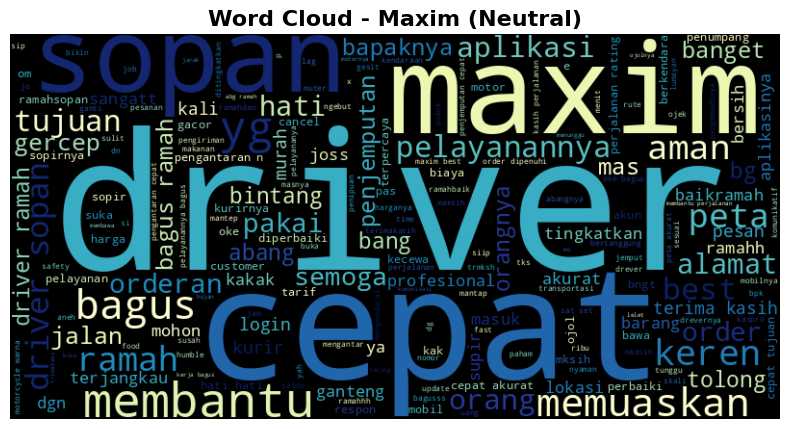

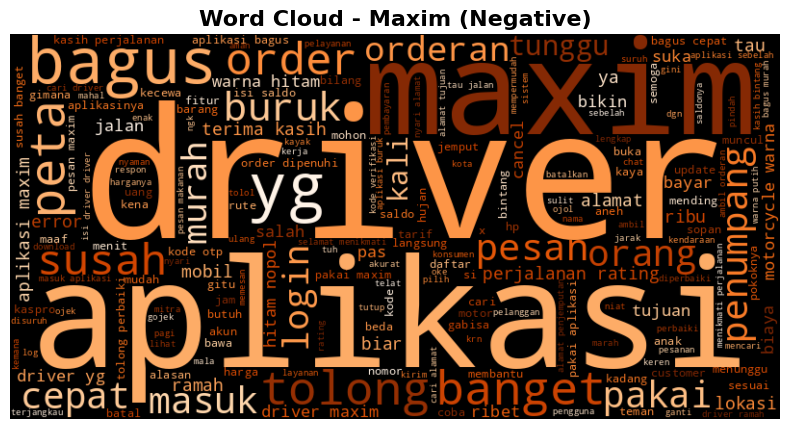

In [ ]:
# Visualisasi Word Cloud untuk masing-masing aplikasi dan sentimen
applications = ['inDrive', 'Grab', 'Gojek', 'Maxim']
sentiments = ['positive', 'neutral', 'negative']

for app in applications:
    for sentiment in sentiments:
        # Filter data berdasarkan aplikasi dan sentimen
        app_data = clean_df[(clean_df['appName'] == app) & (clean_df['polarity'] == sentiment)]
        text = ' '.join(app_data['text_final'].astype(str))  # Gabungkan semua teks

        # Buat word cloud
        wordcloud = WordCloud(
            background_color='black',
            colormap='coolwarm' if sentiment == 'positive' else 'YlGnBu' if sentiment == 'neutral' else 'Oranges',
            max_words=200,
            width=800,
            height=400
        ).generate(text)

        # Plot word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - {app} ({sentiment.capitalize()})', fontsize=16, weight='bold')
        plt.show()


# **DATA SPLIT DAN EKSTRAKSI FITUR MENGGUNAKAN Word2Vec DAN TF-IDF**

# ***Word2Vec***

In [ ]:
# Pisahkan data menjadi fitur dan label (sentimen)
X = clean_df['text_final']
y = clean_df['polarity'].apply(lambda x: 1 if x == 'positive' else (0 if x == 'neutral' else -1))

# Tokenisasi kalimat untuk Word2Vec
X_tokens = X.apply(lambda x: x.split())  # Pisahkan kalimat menjadi kata-kata (tokenisasi)

# Latih model Word2Vec
model = Word2Vec(sentences=X_tokens, vector_size=300, window=5, min_count=2, negative=10, workers=4, sg=1)

# Fungsi untuk mengubah kalimat menjadi vektor rata-rata kata-katanya
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Jika tidak ada kata yang ditemukan, kembalikan vektor nol
    return np.mean(word_vectors, axis=0)  # Rata-rata vektor kata

# Ekstraksi fitur dengan Word2Vec
X_w2v = np.array([vectorize_text(text, model) for text in X])

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_w2v)
# Tampilkan
features_df.head()

0         1         2         3         4         5         6    \
0  0.084593  0.198822  0.064472  0.083700 -0.041907 -0.116732  0.190466   
1  0.059961  0.165197  0.034680  0.111127  0.002197 -0.115268  0.116869   
2  0.011821  0.123569  0.023489  0.125359 -0.030817 -0.098963  0.114230   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4 -0.027282  0.128179 -0.005825  0.238548 -0.022501 -0.193960  0.012221   

        7         8         9    ...       290       291       292       293  \
0  0.222938  0.122715  0.051903  ...  0.022228  0.118806  0.106923 -0.081717   
1  0.186408  0.107672  0.048470  ...  0.037160  0.125805  0.076912 -0.080912   
2  0.184527  0.071279  0.019216  ...  0.016220  0.131749  0.073788 -0.105304   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
4  0.163236 -0.004878  0.058160  ... -0.004500  0.179375  0.052507 -0.183299   

        294       295       296       297       298       299  
0  0.188059  0.134925 -0.093565 -0.092262  0.316599 -0.194365  
1  0.171085  0.100585 -0.062453 -0.082573  0.232474 -0.140116  
2  0.182034  0.135388 -0.050401 -0.071902  0.225344 -0.105085  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4  0.165171  0.173866  0.036309  0.016336  0.214122 -0.018755  

[5 rows x 300 columns]

In [ ]:
# Tampilkan vocabulary Word2Vec dalam format terstruktur
def vocabulary(model):
    # Dapatkan vocabulary dan urutkan berdasarkan indeks
    vocabulary = list(model.wv.index_to_key)

    print("Vocabulary Word2Vec:")
    for index, word in enumerate(vocabulary):
        # Tampilkan kata dan indeksnya
        print(f"{word}: {index}")

        # Batasi output jika vocabulary terlalu besar
        if index > 20:  # Hanya tampilkan 20 kata pertama
            break

# Tampilkan Vocabulary
vocabulary(model)

Vocabulary Word2Vec:
driver: 0
aplikasi: 1
bagus: 2
ramah: 3
banget: 4
tolong: 5
gojek: 6
kasih: 7
membantu: 8
pakai: 9
orderan: 10
cepat: 11
ya: 12
grab: 13
mantap: 14
kalo: 15
terima: 16
pesan: 17
harga: 18
masuk: 19
drivernya: 20
pelayanan: 21


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [ ]:
# Konversi sparse matrix ke dense array
X_train_dense_w2v = X_train.toarray() if sparse.issparse(X_train) else X_train
X_test_dense_w2v = X_test.toarray() if sparse.issparse(X_test) else X_test

In [ ]:
# Reshape data untuk LSTM [samples, timesteps, features]
X_train_reshaped_w2v = X_train_dense_w2v.reshape((X_train_dense_w2v.shape[0], 1, X_train_dense_w2v.shape[1]))
X_test_reshaped_w2v = X_test_dense_w2v.reshape((X_test_dense_w2v.shape[0], 1, X_test_dense_w2v.shape[1]))

In [ ]:
# Menggunakan LabelEncoder untuk mengonversi label kategori menjadi label numerik
label_encoder_w2v = LabelEncoder()

# Mengonversi label teks menjadi label numerik
y_train_enc_w2v = label_encoder_w2v.fit_transform(y_train)
y_test_enc_w2v = label_encoder_w2v.transform(y_test)

# Mengonversi label numerik menjadi one-hot encoding
y_train_cat_w2v = to_categorical(y_train_enc_w2v)
y_test_cat_w2v = to_categorical(y_test_enc_w2v)

# Cek bentuk data setelah konversi
print(f'Bentuk y_train_cat: {y_train_cat_w2v.shape}')
print(f'Bentuk y_test_cat: {y_test_cat_w2v.shape}')

Bentuk y_train_cat: (11120, 3)
Bentuk y_test_cat: (2781, 3)


In [ ]:
# Cek dimensi hasil penggabungan
print("Shape hasil kombinasi:", X_w2v.shape)

# Cek apakah jumlah fitur sesuai
print("Jumlah fitur Word2Vec:", X_w2v.shape[1])
print("Total fitur seharusnya:", X_w2v.shape[1])

# Cek statistik dasar
print("\nStatistik dasar:")
print("Mean:", np.mean(X_w2v))
print("Std:", np.std(X_w2v))
print("Min:", np.min(X_w2v))
print("Max:", np.max(X_w2v))

# Cek proporsi nilai nol
print("\nProporsi nilai nol:", (X_w2v == 0).sum() / X_w2v.size)

Shape hasil kombinasi: (13901, 300)
Jumlah fitur Word2Vec: 300
Total fitur seharusnya: 300

Statistik dasar:
Mean: -0.003482618266607021
Std: 0.10596928094411281
Min: -0.507875919342041
Max: 0.5466442108154297

Proporsi nilai nol: 0.04352204877346953


**MODELING**

In [ ]:
# Create Bi-LSTM model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True),
                 input_shape=(1, X_train_dense_w2v.shape[1])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

# model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 607,875 (2.32 MB)

 Trainable params: 607,875 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Early Stopping
Early_Stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    verbose=1
)

In [ ]:
# Training model
history = model.fit(
    X_train_reshaped_w2v,
    y_train_cat_w2v,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[Early_Stopping],
    verbose=1
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5702 - loss: 0.9395 - val_accuracy: 0.6246 - val_loss: 0.8472
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6582 - loss: 0.8050 - val_accuracy: 0.6641 - val_loss: 0.7844
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6779 - loss: 0.7743 - val_accuracy: 0.6745 - val_loss: 0.7592
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6830 - loss: 0.7537 - val_accuracy: 0.6754 - val_loss: 0.7408
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6953 - loss: 0.7404 - val_accuracy: 0.6727 - val_loss: 0.7476
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7021 - loss: 0.7287 - val_accuracy: 0.6920 - val_loss: 0.7052
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7056 - loss: 0.7167 - val_accuracy: 0.6947 - val_loss: 0.6980
Epoch 8/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7012 - loss: 0.7073 - val_accuracy:

In [ ]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy*100:.2f}%")

Final Training Accuracy: 71.65%
Final Validation Accuracy: 70.68%


In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test_reshaped_w2v, y_test_cat_w2v, verbose=0)
print(f'\nTest accuracy: {test_accuracy:.4f}')


Test accuracy: 0.7224


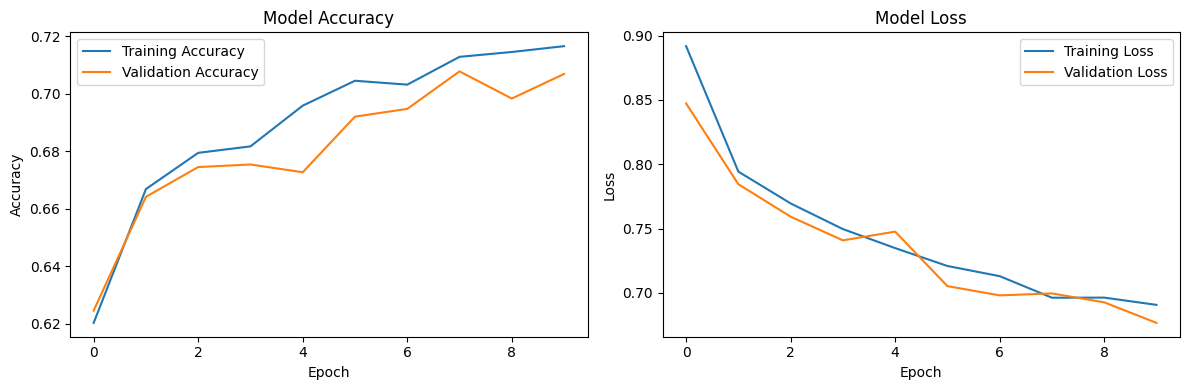

In [ ]:
# Plot history akurasi training dan validation
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediksi hasil pada data test
y_pred = model.predict(X_test_reshaped_w2v)

# Mengambil kelas dengan probabilitas tertinggi
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test_cat_w2v.argmax(axis=1)

# Menampilkan classification report untuk kelas 'negative', 'neutral', dan 'positive'
target_names = ['negative', 'neutral', 'positive']
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.63      0.88      0.74       901
     neutral       0.81      0.50      0.61       604
    positive       0.79      0.72      0.75      1276

    accuracy                           0.72      2781
   macro avg       0.74      0.70      0.70      2781
weighted avg       0.74      0.72      0.72      2781



87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


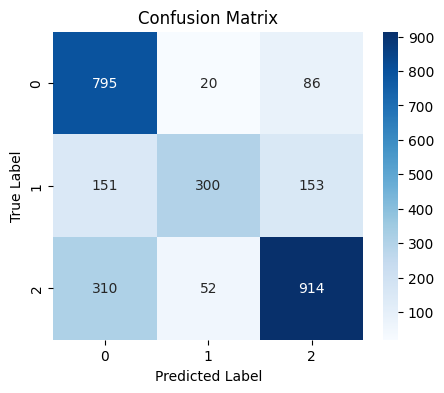

In [ ]:
# Prediksi
y_pred = model.predict(X_test_reshaped_w2v)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat_w2v, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ***TFIDF***

In [ ]:
# Pisahkan data menjadi fitur dan label (sentimen)
X = clean_df['text_final']
y = clean_df['polarity'].apply(lambda x: 1 if x == 'positive' else (0 if x == 'neutral' else -1))

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Tampilkan
features_df.head()

abang  adil  admin  aduh  ajak  akal  aktif  aktivitas  akun  akurat  ...  \
0    0.0   0.0    0.0   0.0   0.0   0.0    0.0        0.0   0.0     0.0  ...   
1    0.0   0.0    0.0   0.0   0.0   0.0    0.0        0.0   0.0     0.0  ...   
2    0.0   0.0    0.0   0.0   0.0   0.0    0.0        0.0   0.0     0.0  ...   
3    0.0   0.0    0.0   0.0   0.0   0.0    0.0        0.0   0.0     0.0  ...   
4    0.0   0.0    0.0   0.0   0.0   0.0    0.0        0.0   0.0     0.0  ...   

   verifikasi  versi  via  voucher   wa  wajah  wajar  wallet  warna   ya  
0         0.0    0.0  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  
1         0.0    0.0  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  
2         0.0    0.0  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  
3         0.0    0.0  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  
4         0.0    0.0  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  

[5 rows x 654 columns]

In [ ]:
# Tampilkan vocabulary dalam format terstruktur
print("Vocabulary:")
for word, index in tfidf.vocabulary_.items():
    print(f"{word}: {index}")

Vocabulary:
update: 641
sepi: 549
orderan: 434
apk: 24
bagus: 41
auto: 38
bermasalah: 71
membantu: 343
mantap: 327
akun: 8
blokir: 85
cancel: 97
drivernya: 152
alasan: 11
mudah: 393
hemat: 206
map: 330
kalo: 243
pesan: 483
gua: 195
bingung: 83
titik: 613
selamat: 542
mitra: 384
indriver: 219
mohon: 389
aplikasi: 25
kompatibel: 280
plus: 492
android: 20
terimakasih: 597
masak: 336
diblokir: 126
tanggal: 584
kesalahan: 270
apapun: 23
good: 183
susah: 578
banget: 44
masuk: 337
lelang: 301
sulit: 572
mencari: 356
order: 433
tolak: 616
ambil: 17
muncul: 396
notif: 416
detik: 117
driver: 151
fiktif: 164
pencet: 461
nama: 400
sehat: 539
pelanggan: 450
sengaja: 548
memilih: 349
payah: 447
car: 99
cuman: 110
top: 621
saldo: 530
indak: 216
diperhatikan: 136
email: 157
respon: 515
app: 28
tujuan: 627
ya: 653
indrive: 218
buruk: 95
argo: 32
kadang: 237
pilih: 486
penumpang: 472
kurir: 287
min: 381
oke: 422
kali: 242
asli: 34
pilihan: 487
dll: 145
puas: 506
pelayanannya: 453
giliran: 177
langsung: 

In [ ]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# Konversi sparse matrix ke dense array
X_train_dense = X_train.toarray() if sparse.issparse(X_train) else X_train
X_test_dense = X_test.toarray() if sparse.issparse(X_test) else X_test

In [ ]:
# Reshape data untuk LSTM [samples, timesteps, features]
X_train_reshaped = X_train_dense.reshape((X_train_dense.shape[0], 1, X_train_dense.shape[1]))
X_test_reshaped = X_test_dense.reshape((X_test_dense.shape[0], 1, X_test_dense.shape[1]))

In [ ]:
# Menggunakan LabelEncoder untuk mengonversi label kategori menjadi label numerik
label_encoder = LabelEncoder()

# Mengonversi label teks menjadi label numerik
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Mengonversi label numerik menjadi one-hot encoding
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Cek bentuk data setelah konversi
print(f'Bentuk y_train_cat: {y_train_cat.shape}')
print(f'Bentuk y_test_cat: {y_test_cat.shape}')

Bentuk y_train_cat: (11120, 3)
Bentuk y_test_cat: (2781, 3)


**MODELING**

In [ ]:
# Definisikan model BI-LSTM
model = Sequential([
    # Layer BI-LSTM
    Bidirectional(LSTM(128, return_sequences=True),
                 input_shape=(1, X_train_dense.shape[1])),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.3),

    # Layer Dense
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes: negatif (0), netral (1), positif (2)
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         801,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 970,371 (3.70 MB)

 Trainable params: 970,371 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping
Early_Stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer= optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Training model
history = model.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[Early_Stopping],
    verbose=1
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5937 - loss: 0.8534 - val_accuracy: 0.8835 - val_loss: 0.3774
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8999 - loss: 0.3222 - val_accuracy: 0.8957 - val_loss: 0.3260
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9160 - loss: 0.2775 - val_accuracy: 0.8939 - val_loss: 0.3293
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9243 - loss: 0.2545 - val_accuracy: 0.8997 - val_loss: 0.3370
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9261 - loss: 0.2504 - val_accuracy: 0.8934 - val_loss: 0.3379
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9308 - loss: 0.2380 - val_accuracy: 0.8916 - val_loss: 0.3466
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


**EVALUASI MODEL**

In [ ]:
#Evaluasi akurasi training dan Validation
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy*100:.2f}%")

Final Training Accuracy: 92.67%
Final Validation Accuracy: 89.16%


In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print(f'\nTest accuracy: {test_accuracy:.4f}')


Test accuracy: 0.8910


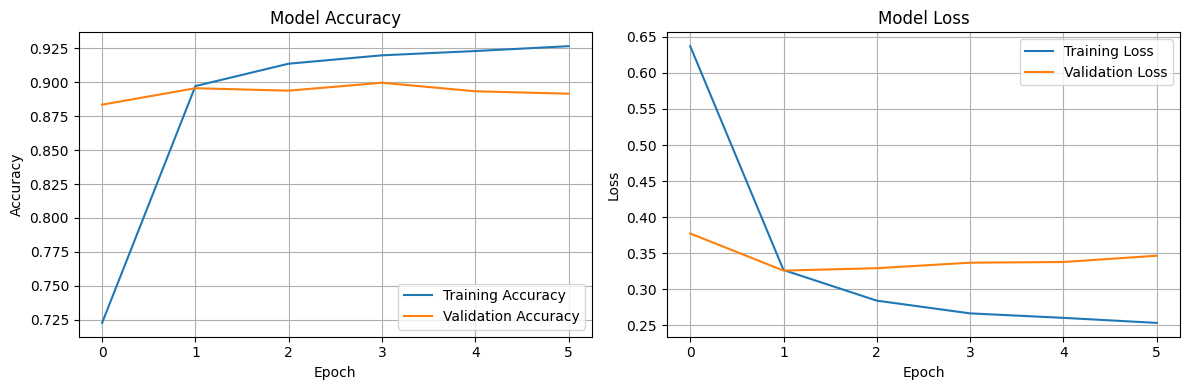

In [ ]:
# Membuat figure dengan 2 subplot
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Prediksi hasil pada data test
y_pred = model.predict(X_test_reshaped)

# Mengambil kelas dengan probabilitas tertinggi
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test_cat.argmax(axis=1)

# Menampilkan classification report untuk kelas 'negative', 'neutral', dan 'positive'
target_names = ['negative', 'neutral', 'positive']
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88       901
     neutral       0.83      0.85      0.84       604
    positive       0.93      0.91      0.92      1276

    accuracy                           0.89      2781
   macro avg       0.88      0.88      0.88      2781
weighted avg       0.89      0.89      0.89      2781



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


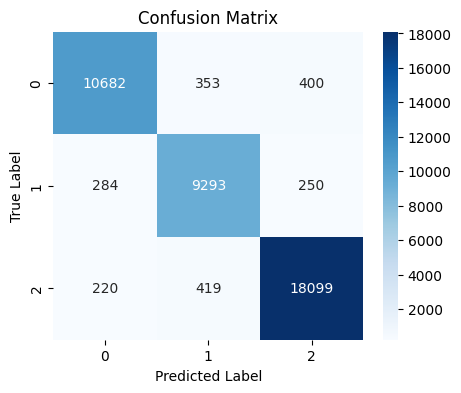

In [ ]:
# Prediksi
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
def predict_sentiment_with_proba(text, tfidf_vectorizer, model):
    # Preprocessing text
    text_vector = tfidf_vectorizer.transform([text])
    text_dense = text_vector.toarray()
    text_reshaped = text_dense.reshape((text_dense.shape[0], 1, text_dense.shape[1]))

    # Prediksi
    prediction_proba = model.predict(text_reshaped, verbose=0)[0]

    # Mendapatkan indeks kelas dengan probabilitas tertinggi
    sentiment_class = np.argmax(prediction_proba)

    # Mapping hasil prediksi
    sentiment_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

    # Membuat dictionary hasil
    results = {
        'predicted_sentiment': sentiment_map[sentiment_class],
        'probabilities': {
            'Negatif': float(prediction_proba[0]),
            'Netral': float(prediction_proba[1]),
            'Positif': float(prediction_proba[2])
        }
    }

    return results

# Fungsi untuk menampilkan hasil prediksi dengan format yang bagus
def display_prediction_results(results):
    print("\n" + "="*50)
    print("HASIL PREDIKSI SENTIMEN")
    print("="*50)
    print(f"\nSentimen yang diprediksi: {results['predicted_sentiment']}")
    print("\nProbabilitas untuk setiap kelas:")
    print("-"*30)
    for sentiment, prob in results['probabilities'].items():
        print(f"{sentiment:<10}: {prob:.4f} ({prob*100:.2f}%)")
    print("="*50)

# Fungsi untuk melakukan prediksi dengan input interaktif
def interactive_prediction(tfidf_vectorizer, model):
    print("\n" + "="*50)
    print("SISTEM PREDIKSI SENTIMEN")
    print("="*50)

    while True:
        # Input teks
        print("\nMasukkan teks yang ingin diprediksi")
        print("(ketik 'quit' untuk keluar):")
        text = input("\n>> ")

        if text.lower() == 'quit':
            print("\nTerima kasih telah menggunakan sistem prediksi sentimen!")
            break

        if not text.strip():
            print("\nError: Teks tidak boleh kosong!")
            continue

        # Lakukan prediksi
        try:
            results = predict_sentiment_with_proba(text, tfidf_vectorizer, model)
            display_prediction_results(results)
        except Exception as e:
            print(f"\nError: Terjadi kesalahan dalam melakukan prediksi: {str(e)}")

        print("\n" + "-"*50)

# Contoh penggunaan:
interactive_prediction(tfidf, model)


SISTEM PREDIKSI SENTIMEN

Masukkan teks yang ingin diprediksi
(ketik 'quit' untuk keluar):

>> Nggak berguna banget tombol chat / telepon resto gak bisa digunakan sama customer. Padahal kalau butuh ganti menu kan lebih enak, nyaman, dan cepat kalau bisa langsung chat sama resto yang bersangkutan

HASIL PREDIKSI SENTIMEN

Sentimen yang diprediksi: Positif

Probabilitas untuk setiap kelas:
------------------------------
Negatif   : 0.0018 (0.18%)
Netral    : 0.0010 (0.10%)
Positif   : 0.9972 (99.72%)

--------------------------------------------------

Masukkan teks yang ingin diprediksi
(ketik 'quit' untuk keluar):

>> Biasanya ada share perjalanan kalau lagi naik ojek, updatean terbaru malah ngga ada menunya, bolak balik cari menu share ngga ada malah mabok pusing mau muntah, dijalanan sambil nyari tombol berbagi perjalanan yg lagi naik ojek. Malah makin jelek aplikasinya bikin kesal

HASIL PREDIKSI SENTIMEN

Sentimen yang diprediksi: Negatif

Probabilitas untuk setiap kelas:
--------

# **Penggabungan TF-IDF dan Word2vec**

# **TF-IDF dan Word2vec**

In [ ]:
# Data preparation
X = clean_df['text_final']
y = clean_df['polarity'].apply(lambda x: 1 if x == 'positive' else (0 if x == 'neutral' else -1))

In [ ]:
# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=1000, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Tampilkan
features_df.head()

abang   ad  adain  adil  admin   aj  ajak  akal  aktif  aktivitas  ...  \
0    0.0  0.0    0.0   0.0    0.0  0.0   0.0   0.0    0.0        0.0  ...   
1    0.0  0.0    0.0   0.0    0.0  0.0   0.0   0.0    0.0        0.0  ...   
2    0.0  0.0    0.0   0.0    0.0  0.0   0.0   0.0    0.0        0.0  ...   
3    0.0  0.0    0.0   0.0    0.0  0.0   0.0   0.0    0.0        0.0  ...   
4    0.0  0.0    0.0   0.0    0.0  0.0   0.0   0.0    0.0        0.0  ...   

   via  voucher   wa  wajah  wajar  wallet  warna   ya  yah   yg  
0  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  0.0  0.0  
1  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  0.0  0.0  
2  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  0.0  0.0  
3  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  0.0  0.0  
4  0.0      0.0  0.0    0.0    0.0     0.0    0.0  0.0  0.0  0.0  

[5 rows x 759 columns]

In [ ]:
# Tampilkan vocabulary dalam format terstruktur
print("Vocabulary:")
for word, index in tfidf.vocabulary_.items():
    print(f"{word}: {index}")

Vocabulary:
update: 744
sepi: 632
orderan: 508
gini: 215
apk: 25
bagus: 41
auto: 39
bermasalah: 75
membantu: 410
mantap: 393
akun: 10
blokir: 92
cancel: 111
drivernya: 178
yg: 758
alasan: 13
mudah: 452
hemat: 246
map: 397
kalo: 288
pesan: 560
gua: 236
bingung: 89
titik: 706
selamat: 625
mitra: 441
indriver: 259
mohon: 447
aplikasi: 26
kompatibel: 335
plus: 571
android: 21
terimakasih: 689
gk: 217
masak: 403
diblokir: 146
sampe: 614
tdk: 681
kesalahan: 319
apapun: 24
good: 224
susah: 668
bgt: 81
dpt: 174
masuk: 404
lelang: 361
sulit: 662
mencari: 421
order: 507
tolak: 709
ambil: 19
muncul: 455
notif: 486
detik: 136
jd: 270
driver: 177
fiktif: 191
pencet: 538
dapet: 132
nama: 459
sehat: 622
pelanggan: 527
sengaja: 631
memilih: 415
payah: 523
car: 112
cuman: 126
top: 714
saldo: 611
diperhatikan: 157
email: 183
respon: 596
udah: 736
dah: 130
app: 29
tujuan: 727
ya: 756
indrive: 258
buruk: 108
argo: 33
kadang: 283
pilih: 564
penumpang: 549
kurir: 345
min: 438
karna: 290
oke: 496
kali: 287
a

In [ ]:
# Word2Vec Feature Extraction
X_tokens = X.apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=X_tokens,
                    vector_size=300,
                    window=5,
                    min_count=2,
                    negative=10,
                    workers=4,
                    sg=1)
# Fungsi untuk mengubah kalimat menjadi vektor rata-rata kata-katanya
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Jika tidak ada kata yang ditemukan, kembalikan vektor nol
    return np.mean(word_vectors, axis=0)  # Rata-rata vektor kata

# Ekstraksi fitur dengan Word2Vec
X_w2v = np.array([vectorize_text(text, w2v_model) for text in X])

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame (X_w2v)
# Tampilkan
features_df.head()

0         1         2         3         4         5         6    \
0  0.013806  0.033104 -0.098321  0.086319  0.033955 -0.107014  0.028393   
1 -0.005055  0.037023 -0.074490  0.072769  0.032094 -0.093938 -0.003176   
2 -0.037908  0.103759 -0.116172  0.099004  0.016657 -0.113715  0.022408   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4 -0.094965  0.256482 -0.234339  0.167659  0.061740 -0.169093  0.015718   

        7         8         9    ...       290       291       292       293  \
0  0.338530 -0.014528  0.097210  ... -0.071265 -0.053213  0.024879  0.037277   
1  0.313387  0.006737  0.032497  ... -0.058218 -0.036188  0.027205  0.012350   
2  0.344366 -0.017369  0.060966  ... -0.049886  0.027329  0.010441  0.024625   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
4  0.440683  0.001026  0.108856  ... -0.117214  0.207451  0.015224  0.059009   

        294       295       296       297       298       299  
0  0.351347  0.217281  0.018271  0.038562  0.160784 -0.066760  
1  0.291198  0.186619  0.008955 -0.017935  0.122178 -0.047429  
2  0.279876  0.219959 -0.014433 -0.014200  0.086061 -0.038355  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4  0.214004  0.334664 -0.080882 -0.080592  0.028215  0.073771  

[5 rows x 300 columns]

In [ ]:
# Tampilkan vocabulary Word2Vec dalam format terstruktur
def vocabulary(model):
    # Dapatkan vocabulary dan urutkan berdasarkan indeks
    vocabulary = list(model.wv.index_to_key)

    print("Vocabulary Word2Vec:")
    for index, word in enumerate(vocabulary):
        # Tampilkan kata dan indeksnya
        print(f"{word}: {index}")

        # Batasi output jika vocabulary terlalu besar
        if index > 10:  # Hanya tampilkan 20 kata pertama
            break

# Tampilkan Vocabulary
vocabulary(w2v_model)

Vocabulary Word2Vec:
driver: 0
aplikasi: 1
yg: 2
ga: 3
bagus: 4
ramah: 5
tolong: 6
gojek: 7
gak: 8
membantu: 9
orderan: 10
cepat: 11


In [ ]:
from sklearn.decomposition import TruncatedSVD

# Reduce TF-IDF
svd_tfidf = TruncatedSVD(n_components=100)
X_tfidf_reduced = svd_tfidf.fit_transform(X_tfidf)

# Scale both
scaler = StandardScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf_reduced)
X_w2v_scaled = scaler.fit_transform(X_w2v)

In [ ]:
def get_weighted_vectors(text, w2v_model, tfidf):
    tokens = text.split()
    tfidf_vector = tfidf.transform([' '.join(tokens)]).toarray()[0]
    word_vectors = []

    for token in tokens:
        if token in w2v_model.wv and token in tfidf.vocabulary_:
            # Mengambil bobot TF-IDF untuk token
            tfidf_weight = tfidf_vector[tfidf.vocabulary_[token]]
            # Mengalikan vektor Word2Vec dengan bobot TF-IDF
            weighted_vector = w2v_model.wv[token] * tfidf_weight
            word_vectors.append(weighted_vector)

    if not word_vectors:
        return np.zeros(w2v_model.vector_size)

    return np.mean(word_vectors, axis=0)

In [ ]:
# Mengkombinasikan fitur TF-IDF dan Word2Vec
X_w2v = np.array([get_weighted_vectors(text, w2v_model, tfidf) for text in X])

In [ ]:
# Combine
X_combined = np.hstack((X_tfidf_scaled, X_w2v_scaled))

In [ ]:
# Menggabungkan kedua fitur
X_combined = sparse.hstack((X_tfidf, sparse.csr_matrix(X_w2v))).toarray()

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X_combined

array([[ 0.        ,  0.        ,  0.        , ...,  0.01732078,
         0.08728302, -0.03675968],
       [ 0.        ,  0.        ,  0.        , ..., -0.00937041,
         0.10765011, -0.05986047],
       [ 0.        ,  0.        ,  0.        , ..., -0.00339503,
         0.05054491, -0.0226095 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.01914421,
         0.01355405, -0.00728014],
       [ 0.        ,  0.        ,  0.        , ...,  0.015712  ,
         0.05710176, -0.02994514],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Cek dimensi hasil penggabungan
print("Shape hasil kombinasi:", X_combined.shape)

# Cek apakah jumlah fitur sesuai
print("Jumlah fitur TF-IDF:", X_tfidf.shape[1])
print("Jumlah fitur Word2Vec:", X_w2v.shape[1])
print("Total fitur seharusnya:", X_tfidf.shape[1] + X_w2v.shape[1])

# Cek statistik dasar
print("\nStatistik dasar:")
print("Mean:", np.mean(X_combined))
print("Std:", np.std(X_combined))
print("Min:", np.min(X_combined))
print("Max:", np.max(X_combined))

# Cek proporsi nilai nol
print("\nProporsi nilai nol:", (X_combined == 0).sum() / X_combined.size)

Shape hasil kombinasi: (13901, 1059)
Jumlah fitur TF-IDF: 759
Jumlah fitur Word2Vec: 300
Total fitur seharusnya: 1059

Statistik dasar:
Mean: 0.0014937900763567586
Std: 0.04913894139634052
Min: -0.5232105255126953
Max: 1.0

Proporsi nilai nol: 0.7373147725664807


In [ ]:
# Reshape data untuk BI-LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Cek bentuk data setelah konversi
print(f'Bentuk y_train_cat: {y_train_cat.shape}')
print(f'Bentuk y_test_cat: {y_test_cat.shape}')

Bentuk y_train_cat: (11120, 3)
Bentuk y_test_cat: (2781, 3)


In [ ]:
# 1. Cek data leakage pada teks mentah sebelum feature extraction
X_train_raw, X_test_raw, _, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_words = set(' '.join(X_train_raw).split())
test_words = set(' '.join(X_test_raw).split())
overlap_words = train_words.intersection(test_words)

print("1. Vocabulary Overlap Check:")
print(f"Total kata unik di training set: {len(train_words)}")
print(f"Total kata unik di test set: {len(test_words)}")
print(f"Jumlah kata yang overlap: {len(overlap_words)}")
print(f"Persentase overlap: {len(overlap_words)/len(test_words)*100:.2f}%")

# 2. Cek distribusi kelas
from collections import Counter
print("\n2. Class Distribution Check:")
print("Distribusi kelas di training:")
print(Counter(y_train))
print("\nDistribusi kelas di testing:")
print(Counter(y_test))

# 3. Cek distribusi fitur TF-IDF
print("\n3. TF-IDF Feature Distribution Check:")
train_mean = np.mean(X_train, axis=0)
test_mean = np.mean(X_test, axis=0)
feature_diff = np.abs(train_mean - test_mean)
print(f"Rata-rata perbedaan distribusi fitur: {np.mean(feature_diff):.4f}")
print(f"Maksimum perbedaan distribusi fitur: {np.max(feature_diff):.4f}")

# 4. Cek data leakage di embedding
print("\n4. Word Embedding Similarity Check:")
train_mean_embedding = np.mean(X_train[:, -300:], axis=0)  # ambil 300 fitur terakhir (Word2Vec)
test_mean_embedding = np.mean(X_test[:, -300:], axis=0)
embedding_similarity = np.dot(train_mean_embedding, test_mean_embedding) / (
    np.linalg.norm(train_mean_embedding) * np.linalg.norm(test_mean_embedding)
)
print(f"Similaritas rata-rata embedding: {embedding_similarity:.4f}")

# 5. Kesimpulan
print("\n5. Analisis Data Leakage:")
print("a. Vocabulary overlap:")
if len(overlap_words)/len(test_words)*100 > 90:
    print("   ⚠️ WARNING: Overlap vocabulary sangat tinggi (>90%)")
elif len(overlap_words)/len(test_words)*100 < 30:
    print("   ⚠️ WARNING: Overlap vocabulary sangat rendah (<30%)")
else:
    print("   ✅ Overlap vocabulary dalam rentang normal")

print("\nb. Distribusi kelas:")
train_dist = Counter(y_train)
test_dist = Counter(y_test)
if all(abs(train_dist[k]/len(y_train) - test_dist[k]/len(y_test)) < 0.05 for k in train_dist.keys()):
    print("   ✅ Distribusi kelas seimbang antara train dan test")
else:
    print("   ⚠️ WARNING: Ada ketidakseimbangan distribusi kelas")

print("\nc. Feature distribution:")
if np.mean(feature_diff) > 0.5:
    print("   ⚠️ WARNING: Perbedaan distribusi fitur signifikan")
else:
    print("   ✅ Distribusi fitur relatif sama antara train dan test")

print("\nd. Embedding similarity:")
if embedding_similarity > 0.95:
    print("   ⚠️ WARNING: Similaritas embedding terlalu tinggi")
elif embedding_similarity < 0.3:
    print("   ⚠️ WARNING: Similaritas embedding terlalu rendah")
else:
    print("   ✅ Similaritas embedding dalam rentang normal")

1. Vocabulary Overlap Check:
Total kata unik di training set: 11218
Total kata unik di test set: 4743
Jumlah kata yang overlap: 2879
Persentase overlap: 60.70%

2. Class Distribution Check:
Distribusi kelas di training:
Counter({1: 5154, -1: 3446, 0: 2520})

Distribusi kelas di testing:
Counter({1: 1289, -1: 862, 0: 630})

3. TF-IDF Feature Distribution Check:
Rata-rata perbedaan distribusi fitur: 0.0006
Maksimum perbedaan distribusi fitur: 0.0038

4. Word Embedding Similarity Check:
Similaritas rata-rata embedding: 0.9999

5. Analisis Data Leakage:
a. Vocabulary overlap:
   ✅ Overlap vocabulary dalam rentang normal

b. Distribusi kelas:
   ✅ Distribusi kelas seimbang antara train dan test

c. Feature distribution:
   ✅ Distribusi fitur relatif sama antara train dan test

d. Embedding similarity:
   ⚠️ WARNING: Similaritas embedding terlalu tinggi


# **Modeling**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

# Model RNN
model_rnn = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1, 128)              │         152,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,595 (650.76 KB)

 Trainable params: 166,595 (650.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Model LSTM
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │         608,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,843 (2.52 MB)

 Trainable params: 659,843 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model BiLSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True),
                 input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_cat.shape[1], activation='softmax')
])

# Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │       1,216,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385,091 (5.28 MB)

 Trainable params: 1,385,091 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Early Stopping
Early_Stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [ ]:
# Training model
history = model.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[Early_Stopping],
    verbose=1
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5894 - loss: 0.8948 - val_accuracy: 0.8278 - val_loss: 0.5027
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8723 - loss: 0.4218 - val_accuracy: 0.8539 - val_loss: 0.4213
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9021 - loss: 0.3203 - val_accuracy: 0.8602 - val_loss: 0.4249
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9076 - loss: 0.2955 - val_accuracy: 0.8737 - val_loss: 0.4100
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9186 - loss: 0.2634 - val_accuracy: 0.8710 - val_loss: 0.4169
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9190 - loss: 0.2572 - val_accuracy: 0.8728 - val_loss: 0.4332
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


# **Evaluasi dan Testing Model**

In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print(f'\nTest accuracy: {test_accuracy:.4f}')


Test accuracy: 0.8731


In [ ]:
# Evaluasi model
train_loss, train_accuracy = model.evaluate(X_train_reshaped, y_train_cat, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)

print("Hasil Evaluasi Model:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

Hasil Evaluasi Model:
Training Accuracy: 0.8248
Testing Accuracy: 0.8109
Training Loss: 0.4487
Testing Loss: 0.4695


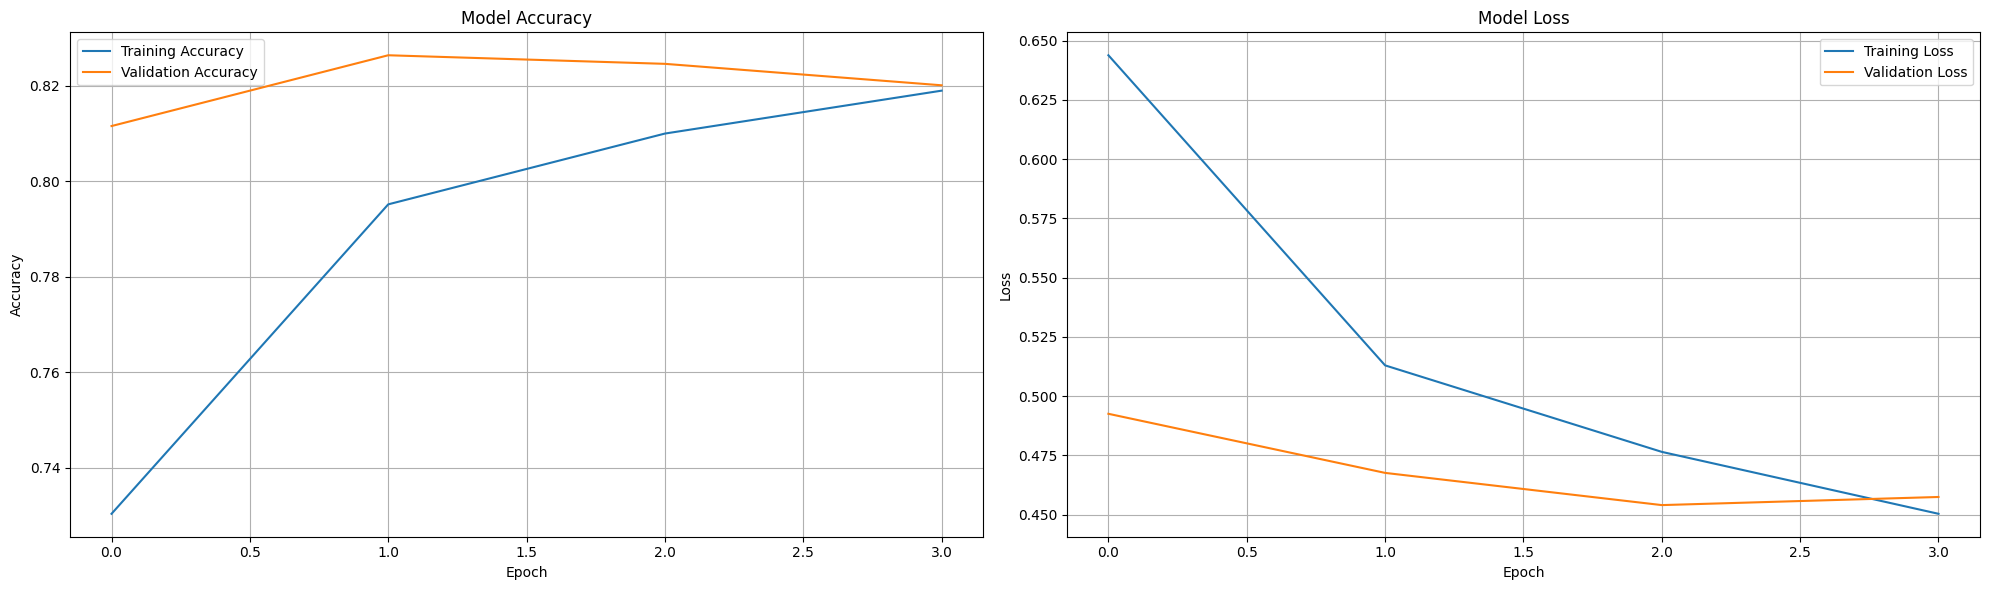

In [ ]:
# Buat figure dengan 2 subplot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot Accuracy di subplot pertama
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Loss di subplot kedua
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Atur jarak antar subplot
plt.tight_layout()

# Tampilkan plot
plt.show()

In [ ]:
# Prediksi
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


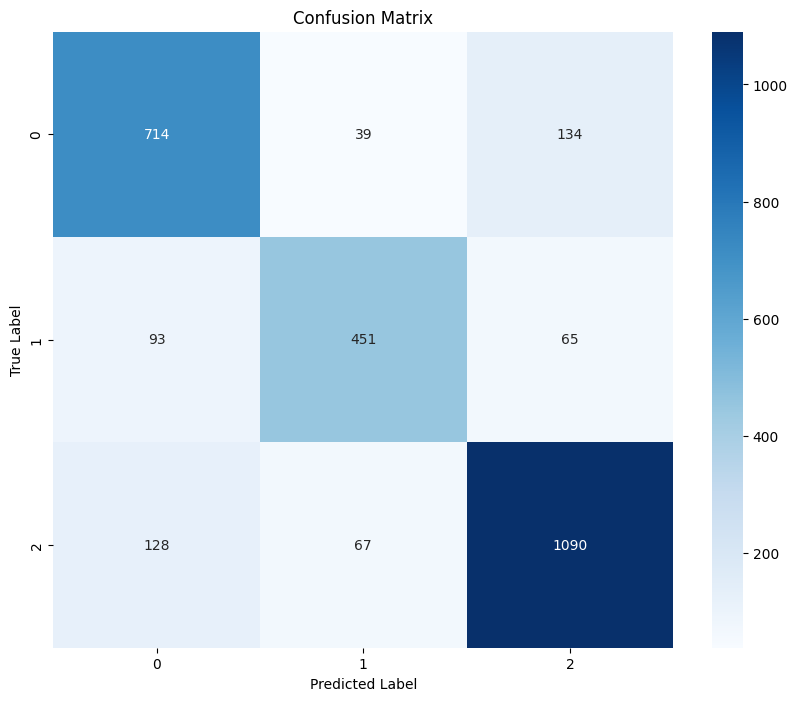

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=['Negative', 'Neutral', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.80      0.78       887
     Neutral       0.81      0.74      0.77       609
    Positive       0.85      0.85      0.85      1285

    accuracy                           0.81      2781
   macro avg       0.81      0.80      0.80      2781
weighted avg       0.81      0.81      0.81      2781



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


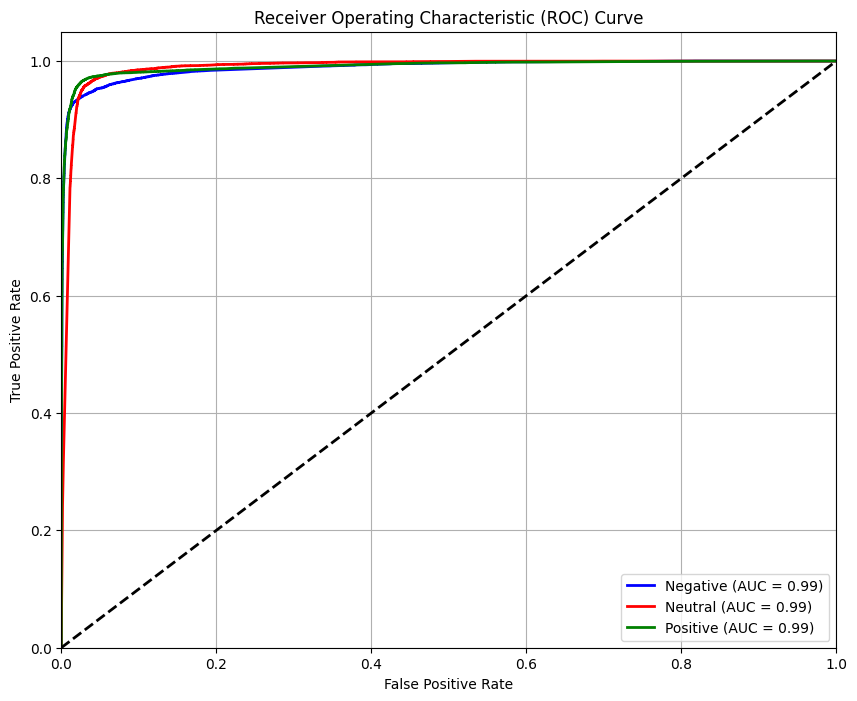


AUC Scores:
Negative: 0.9887
Neutral: 0.9888
Positive: 0.9910


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Mendapatkan probabilitas prediksi untuk setiap kelas
y_pred_proba = model.predict(X_test_reshaped)

# Hitung ROC curve dan AUC untuk setiap kelas
n_classes = y_test_cat.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
labels = ['Negative', 'Neutral', 'Positive']

for i, color, label in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores
print("\nAUC Scores:")
for i, label in enumerate(labels):
    print(f"{label}: {roc_auc[i]:.4f}")

In [ ]:
def create_prediction_interface():
    def predict_sentiment(text):
        # Transform menggunakan TF-IDF
        text_tfidf = tfidf.transform([text])

        # Transform menggunakan Word2Vec dan weighted dengan TF-IDF
        text_w2v = np.array([get_weighted_vectors(text, w2v_model, tfidf)])

        # Gabungkan kedua fitur
        text_combined = sparse.hstack((text_tfidf, sparse.csr_matrix(text_w2v))).toarray()

        # Reshape untuk LSTM
        text_reshaped = text_combined.reshape((1, 1, text_combined.shape[1]))

        # Prediksi
        prediction_proba = model.predict(text_reshaped, verbose=0)[0]

        # Mendapatkan indeks kelas dengan probabilitas tertinggi
        sentiment_class = np.argmax(prediction_proba)

        # Mapping hasil prediksi
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

        # Membuat dictionary hasil
        results = {
            'predicted_sentiment': sentiment_map[sentiment_class],
            'probabilities': {
                'Negative': float(prediction_proba[0]),
                'Neutral': float(prediction_proba[1]),
                'Positive': float(prediction_proba[2])
            }
        }

        return results

    def display_prediction_results(output, text, results):
        with output:
            print("\n" + "="*50)
            print("HASIL PREDIKSI SENTIMEN")
            print("="*50)
            print(f"\nTeks Input: {text}")
            print(f"\nSentimen yang diprediksi: {results['predicted_sentiment']}")
            print("\nProbabilitas untuk setiap kelas:")
            print("-"*30)
            for sentiment, prob in results['probabilities'].items():
                print(f"{sentiment:<10}: {prob:.4f} ({prob*100:.2f}%)")
            print("\nInformasi Preprocessing:")
            print("-"*30)
            print(f"Tokens: {text.split()}")
            print("="*50)

    def on_button_click(b):
        text = text_input.value
        if text.strip():
            try:
                results = predict_sentiment(text)
                output.clear_output()
                display_prediction_results(output, text, results)
            except Exception as e:
                output.clear_output()
                with output:
                    print(f"\nError: Terjadi kesalahan dalam melakukan prediksi: {str(e)}")
        else:
            output.clear_output()
            with output:
                print("\nError: Teks tidak boleh kosong!")

    # Widget Interface
    text_input = widgets.Textarea(
        value='',
        placeholder='Masukkan teks untuk analisis sentimen...',
        description='Teks:',
        disabled=False,
        layout=widgets.Layout(width='500px', height='100px')
    )

    button = widgets.Button(
        description='Prediksi Sentimen',
        button_style='success',
        layout=widgets.Layout(width='200px')
    )

    output = widgets.Output()

    button.on_click(on_button_click)

    # Tampilkan widgets
    display(widgets.VBox([
        text_input,
        button,
        output
    ]))

# Menjalankan interface
create_prediction_interface()